#Train

In [1]:
import pandas as pd
import os
df= pd.read_csv("full_data_imputed.csv",index_col=False)
df.columns
df.drop('Unnamed: 0',axis=1,inplace=True)

In [2]:
df.columns

Index(['Local Time', 'Aqi', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2',
       'Train Name', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed',
       'Latitude', 'Longitude'],
      dtype='object')

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()
df_copy['Local Time'] = pd.to_datetime(df_copy['Local Time'])
print(df_copy.isnull().sum())

# Giả sử df_copy đã có sẵn
df_copy = df_copy.set_index('Local Time')
weather_cols = ['Clouds', 'Precipitation', 'Pressure',
                'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed']

df_copy[weather_cols] = df_copy[weather_cols].ffill().bfill()

# Encode train name
# le = LabelEncoder()
# df_copy['Train Name'] = le.fit_transform(df_copy['Train Name'])
df_copy['Month']=df_copy.index.month # Access month from index
df_copy['Day']=df_copy.index.day # Access day from index
df_copy['Hour']=df_copy.index.hour # Access hour from index
df_copy['Weekday']=df_copy.index.weekday # Access weekday from index
df_copy.drop('Latitude',axis=1,inplace=True)
df_copy.drop('Longitude',axis=1,inplace=True)


# ===============================
# 3️⃣ Chia train/val/test theo năm
# ===============================
train_data = df_copy.loc['2023':'2024']
val_data   = df_copy.loc['2025-01':'2025-06']
test_data  = df_copy.loc['2025-07':'2025-09']

target_col = 'Aqi'
X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val     = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test   = test_data.drop(columns=[target_col]), test_data[target_col]

# ===============================
# 4️⃣ Scale dữ liệu
# ===============================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

Local Time           0
Aqi                  0
Co                   0
No2                  0
O3                   0
Pm10                 0
Pm25                 0
So2                  0
Train Name           0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV_Index             0
Wind Speed           0
Latitude             0
Longitude            0
dtype: int64


In [4]:
#Print shape data
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(685464, 18)
(169686, 18)
(86283, 18)


In [5]:
# ===============================
# 5️⃣ Tạo dataset cho LSTM
# ===============================
import tensorflow as tf # Import TensorFlow here

length = 24  # 1 ngày
batch_size = 32
n_features = X_train_scaled.shape[1]

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled, targets=y_train_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled, targets=y_val_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled, targets=y_test_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

In [6]:
# ===============================
# 6️⃣ Custom metrics
# ===============================
import tensorflow as tf
from tensorflow.keras import backend as K

def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))

def r2_keras(y_true, y_pred):
    # Cast y_pred to the same data type as y_true
    y_pred = tf.cast(y_pred, y_true.dtype)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# ===============================
# 7️⃣ Model LSTM
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(length, n_features)), # Changed batch_input_shape to input_shape and moved inside LSTM
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[
        rmsle_custom,
        'mae',
        'mse',
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        'mape',
        'msle',
        r2_keras
    ]
)

# ===============================
# 8️⃣ Callbacks
# ===============================
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3,
    verbose=1, min_lr=1e-6
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# ===============================
# 8️⃣ Train model
# ===============================
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[es, plateau],
    verbose=1
)


Epoch 1/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 412s 19ms/step - loss: 0.0431 - mae: 0.1445 - mape: 99.7018 - mse: 0.0431 - msle: 0.0061 - r2_keras: -1.9026 - rmse: 0.2063 - rmsle_custom: 0.0363 - val_loss: 0.0537 - val_mae: 0.1764 - val_mape: 205.6063 - val_mse: 0.0537 - val_msle: 0.0086 - val_r2_keras: -0.9957 - val_rmse: 0.2317 - val_rmsle_custom: 0.0607 - learning_rate: 0.0010
Epoch 2/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 415s 19ms/step - loss: 0.0186 - mae: 0.0869 - mape: 55.7849 - mse: 0.0186 - msle: 0.0019 - r2_keras: -0.0476 - rmse: 0.1358 - rmsle_custom: 0.0218 - val_loss: 0.0196 - val_mae: 0.1148 - val_mape: 118.7656 - val_mse: 0.0196 - val_msle: 0.0038 - val_r2_keras: 0.1059 - val_rmse: 0.1400 - val_rmsle_custom: 0.0397 - learning_rate: 0.0010
Epoch 3/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 440s 21ms/step - loss: 0.0134 - mae: 0.0733 - mape: 44.4284 - mse: 0.0134 - msle: 0.0013 - r2_keras: 0.2715 - rmse: 0.1145 - rmsle_custom: 0.0188 - val_loss: 0.0145 - val_mae: 0.0942 - val_mape: 10

In [8]:
import matplotlib.pyplot as plt

def plot_all_losses(hist):
    """
    Vẽ tất cả các loss và metric (train/val) trong history của model.
    """
    # Lấy tất cả key trong history
    keys = list(hist.history.keys())

    # Chỉ lấy các metric chính (bỏ qua val_)
    main_metrics = [k for k in keys if not k.startswith('val_')]

    for key in main_metrics:
        # Bỏ qua các metric không cần thiết
        if any(metric in key for metric in [
            'loss', 'mae', 'mse', 'rmse', 'rmsle', 'r2'
        ]):
            plt.figure(figsize=(10, 6))

            # Plot train metric
            plt.plot(hist.history[key], label=f'Train {key.replace("_", " ").title()}', linewidth=2)

            # Plot val metric nếu có
            val_key = f'val_{key}'
            if val_key in hist.history:
                plt.plot(hist.history[val_key], label=f'Val {key.replace("_", " ").title()}', linestyle='--', linewidth=2)

            plt.title(f'Model {key.replace("_", " ").title()} over Epochs', fontsize=14)
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel(key.replace("_", " ").title(), fontsize=12)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

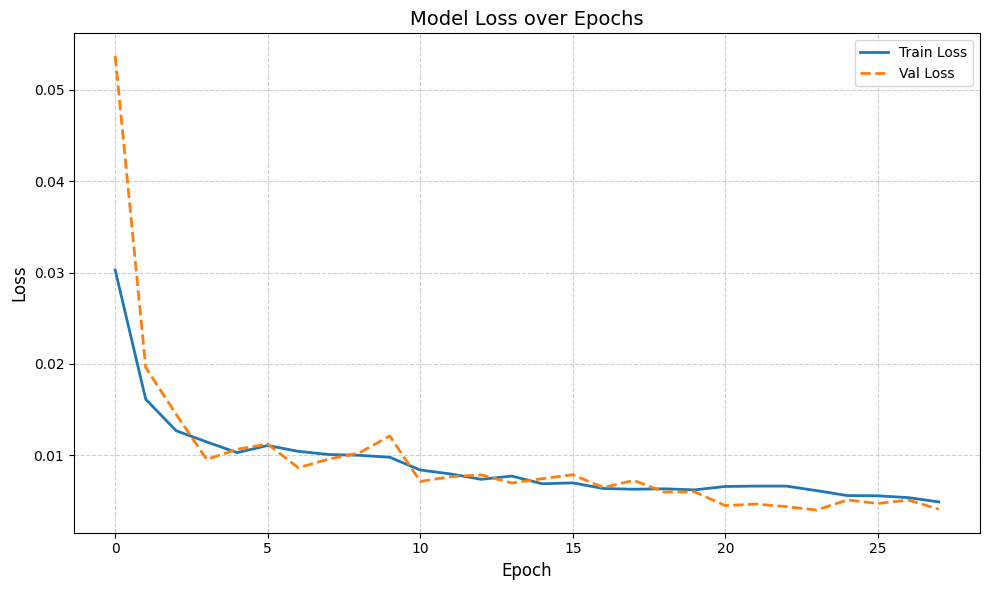

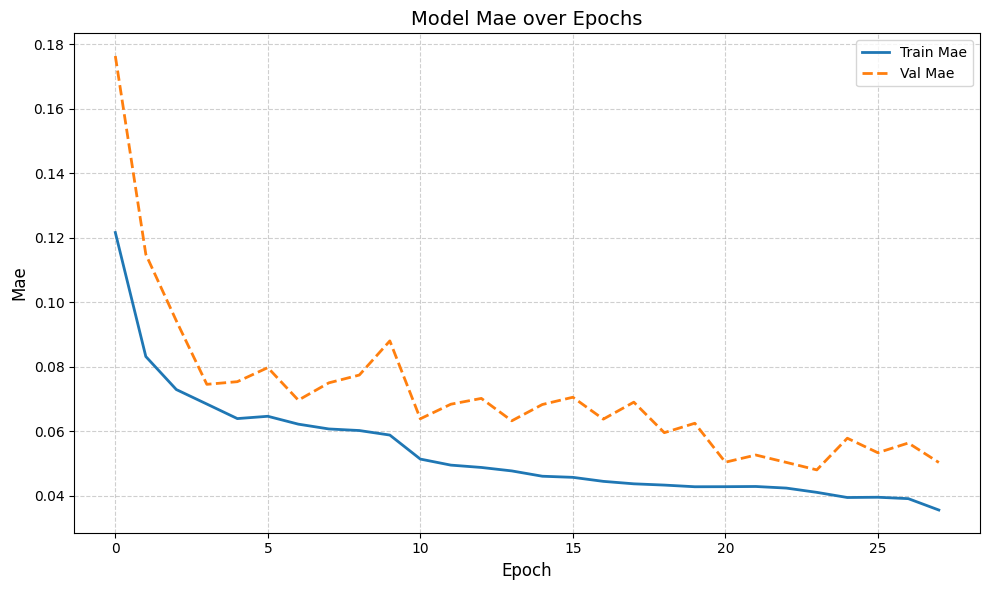

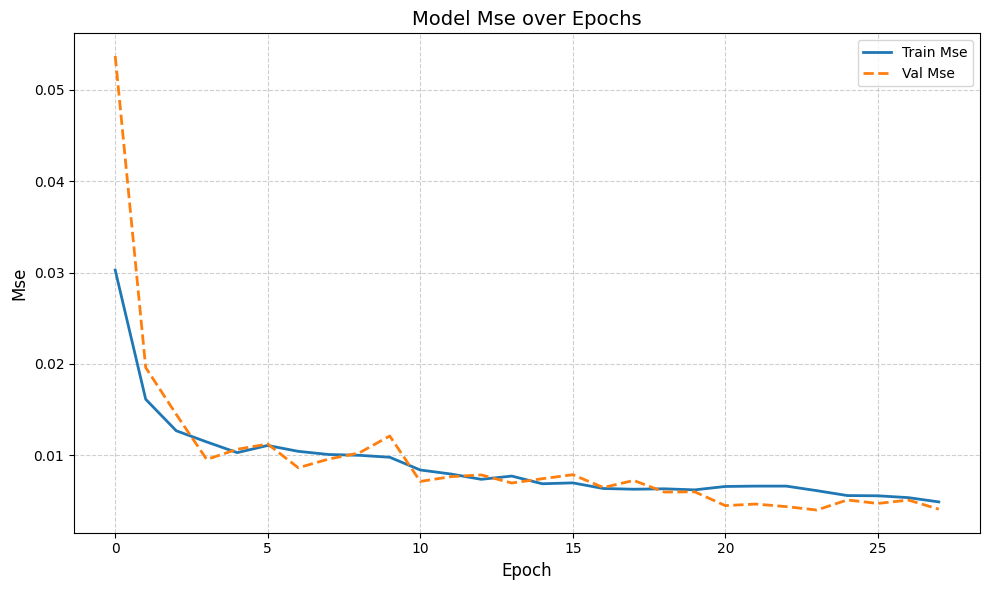

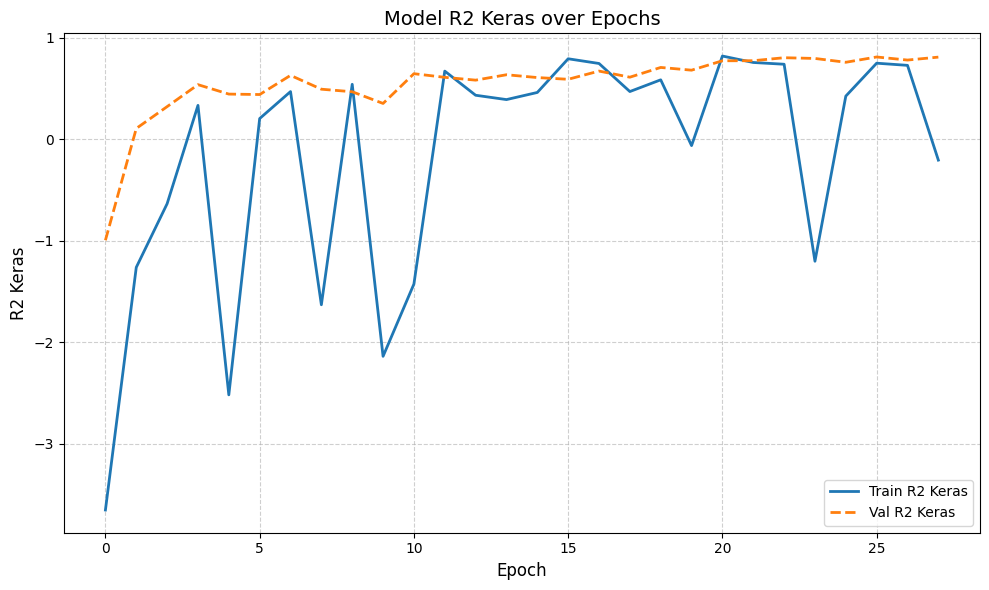

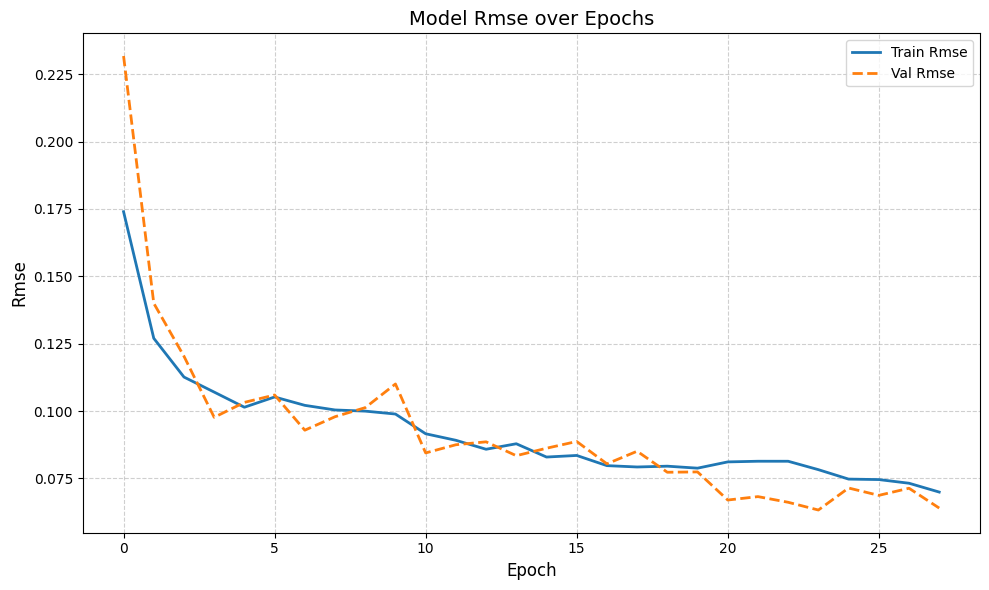

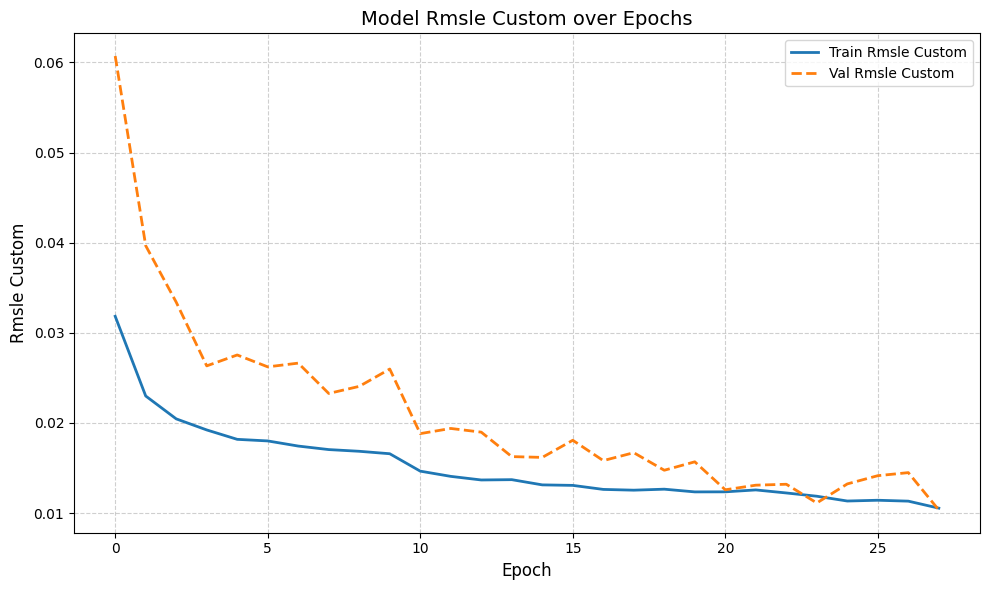

In [9]:
plot_all_losses(hist)

In [18]:
def save_lstm_model(model, model_name="lstm_model"):
    """
    Saves the trained LSTM model to Google Drive.

    Args:
        model: The trained Keras model object.
        model_name (str): The base name for the saved model file (without extension).
    """
    # Define the path to save the model
    model_save_path =model_name+".h5"

    print(f"Saving the model to: {model_save_path}")
    model.save(model_save_path)
    print("Model saved successfully!")

# Call the function to save the model
save_lstm_model(model, "bilstm")

Saving the model to: bilstm.h5
Model saved successfully!


In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics
y_hat_test=model.predict(test_dataset)
y_hat_test_inv = scaler_y.inverse_transform(y_hat_test)
y_test_inv = scaler_y.inverse_transform(y_test_scaled[:len(y_hat_test)])

2696/2696 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow.keras.metrics import MeanSquaredLogarithmicError

def evaluate_and_print_metrics(y_true_inv, y_hat_inv, X_test_scaled):
    """
    Calculates and prints various evaluation metrics.

    Args:
        y_true_inv (np.ndarray): The inverse-scaled true values.
        y_hat_inv (np.ndarray): The inverse-scaled predicted values.
        X_test_scaled (np.ndarray): The scaled test features (used for adjusted R-squared).
    """
    # Calculate R-squared
    r2 = r2_score(y_true_inv, y_hat_inv)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true_inv, y_hat_inv)

    #MSE
    mse = mean_squared_error(y_true_inv, y_hat_inv)

    #RMSE
    rmse = np.sqrt(mse)

    #MSLE
    msle_metric = MeanSquaredLogarithmicError()
    msle = msle_metric(y_true_inv, y_hat_inv).numpy() # Calculate MSLE using the Keras metric

    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true_inv - y_hat_inv) / (y_true_inv + 1e-8))) * 100


    # Calculate Adjusted R-squared
    n = len(y_true_inv)
    p = X_test_scaled.shape[1] # Use the number of features from the scaled data
    # Ensure n > p + 1 for adjusted R-squared calculation
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = np.nan # Cannot calculate adjusted R-squared

    print(f"Test Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSLE: {msle:.4f}")
    # RMSLE can be calculated from MSLE
    rmsle = np.sqrt(msle)
    print(f"  RMSLE: {rmsle:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print(f"  Adjusted R-squared: {adjusted_r2:.4f}")

In [14]:
#Call
evaluate_and_print_metrics(y_test_inv, y_hat_test_inv, X_test_scaled)

Test Metrics:
  MAE: 7.0079
  MSE: 334.1439
  RMSE: 18.2796
  MSLE: 0.0729
  RMSLE: 0.2699
  MAPE: 13.8301
  R-squared: 0.6471
  Adjusted R-squared: 0.6470


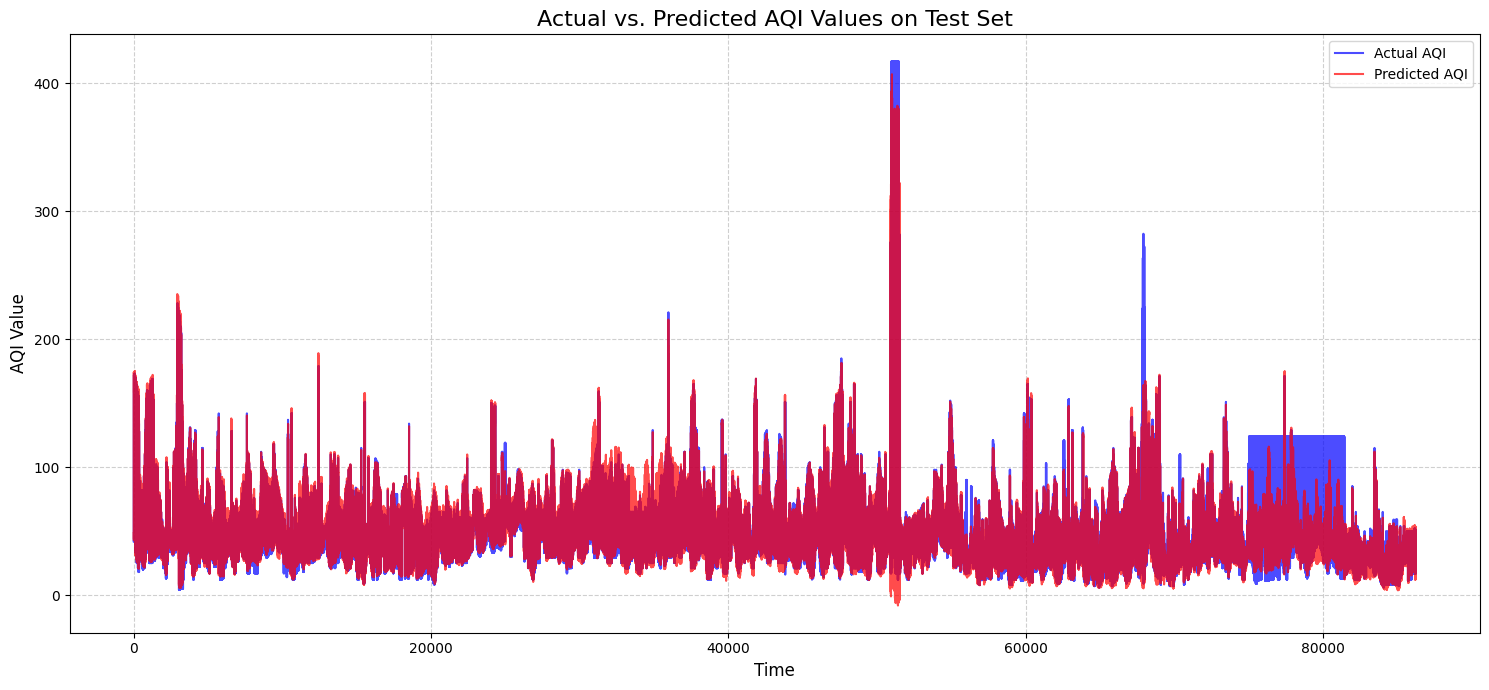

In [15]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the actual test values
plt.plot(y_test_inv, label='Actual AQI', color='blue', alpha=0.7)

# Plot the predicted values
# Ensure y_hat_test_inv has the same length as y_test_inv for plotting
plt.plot(y_hat_test_inv, label='Predicted AQI', color='red', alpha=0.7)

# Add title and labels
plt.title('Actual vs. Predicted AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

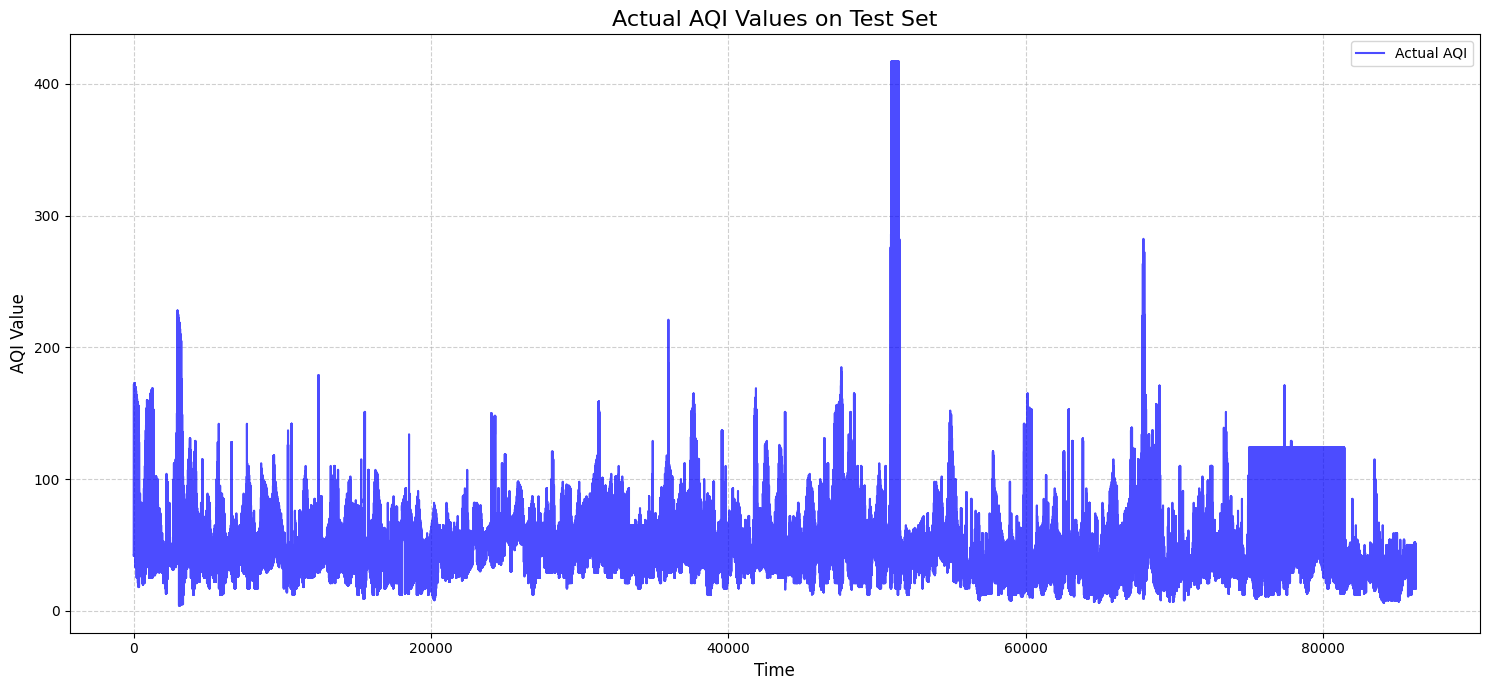

In [16]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the actual test values
plt.plot(y_test_inv, label='Actual AQI', color='blue', alpha=0.7)

# Add title and labels
plt.title('Actual AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

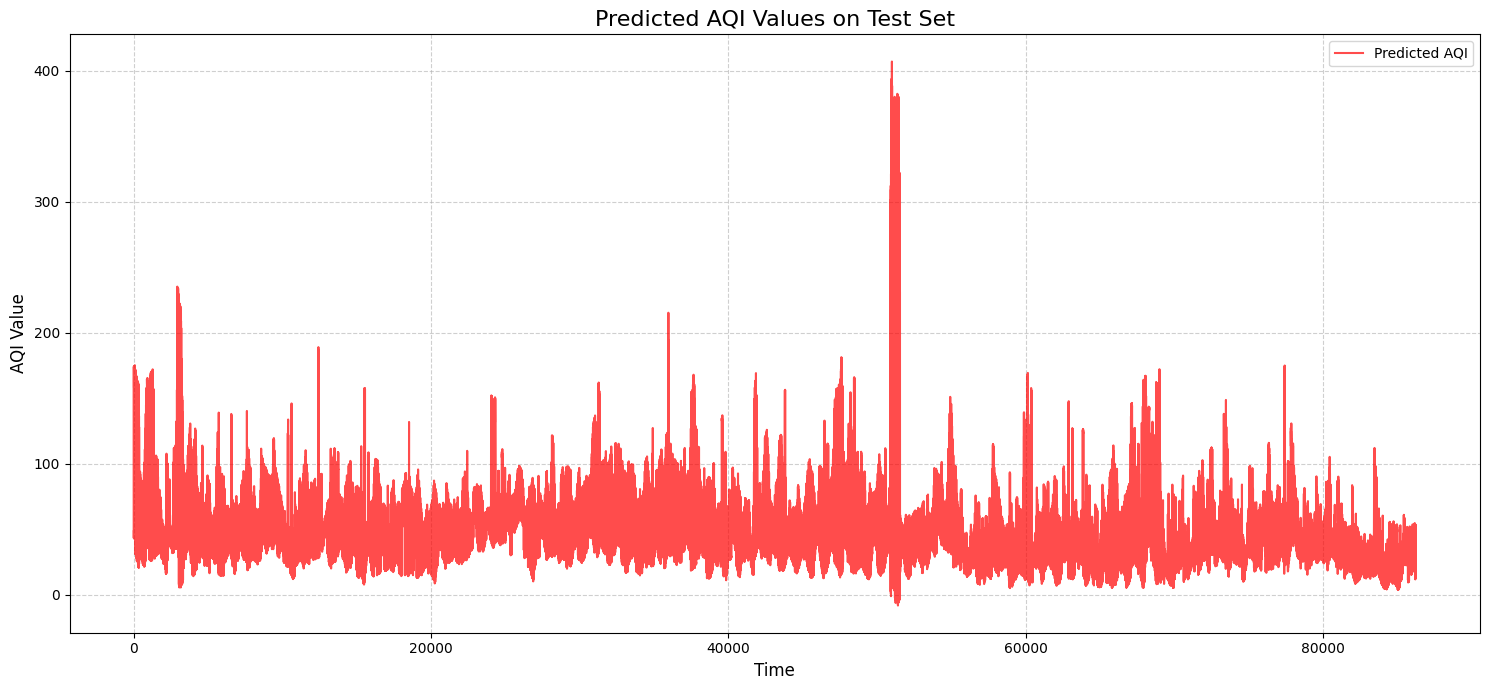

In [17]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the predicted values
plt.plot(y_hat_test_inv, label='Predicted AQI', color='red', alpha=0.7)

# Add title and labels
plt.title('Predicted AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()